In [1]:
import gdal
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load ./neon_aop_lidar_python_functions/raster2array.py
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = float(dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']))
            band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

In [3]:
serc_tile,serc_metadata = raster2array(r'Day2_LiDAR_Intro/TEAK_Aspect_Tiles/NEON_D17_TEAK_DP3_320000_4100000_aspect.tif')
serc_tile

array([[163.71200562, 160.04100037, 159.0019989 , ...,  18.74500084,
         19.59300041,  25.36899948],
       [164.477005  , 161.91799927, 160.12800598, ...,  17.50900078,
         22.22900009,  34.88100052],
       [165.58799744, 163.79400635, 161.91799927, ...,  23.70000076,
         33.625     ,  49.83300018],
       ...,
       [242.97200012, 247.46499634, 252.26300049, ..., 240.147995  ,
        249.82499695, 256.61401367],
       [251.91499329, 256.54400635, 259.59899902, ..., 237.49099731,
        237.39199829, 231.25      ],
       [254.6499939 , 257.04800415, 256.69799805, ..., 235.27000427,
        231.46699524, 224.64500427]])

In [4]:
serc_metadata

{'array_cols': 1000,
 'array_rows': 1000,
 'bands': 1,
 'driver': 'GeoTIFF',
 'extent': (320000.0, 321000.0, 4100000.0, 4101000.0),
 'geotransform': (320000.0, 1.0, 0.0, 4101000.0, 0.0, -1.0),
 'noDataValue': -9999.0,
 'pixelHeight': -1.0,
 'pixelWidth': 1.0,
 'projection': 'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]',
 'scaleFactor': 1.0}

In [5]:
serc_chm_reclass = serc_tile.copy() # doe th same as copy.copy(...)

In [6]:
# define the classes
serc_chm_reclass[np.where((serc_tile>0) & (serc_tile<45)) or np.where((serc_tile>315) & (serc_tile<360))] = 1

serc_chm_reclass[np.where((serc_tile>135) & (serc_tile<225))] = 2

serc_chm_reclass[np.where((serc_tile>=45) & (serc_tile<=135)) or np.where((serc_tile>=225) & (serc_tile<=315))] = 3


In [7]:
serc_chm_reclass


array([[  2.        ,   2.        ,   2.        , ...,   1.        ,
          1.        ,   1.        ],
       [  2.        ,   2.        ,   2.        , ...,   1.        ,
          1.        ,   1.        ],
       [  2.        ,   2.        ,   2.        , ...,   1.        ,
          1.        ,   3.        ],
       ...,
       [242.97200012, 247.46499634, 252.26300049, ..., 240.147995  ,
        249.82499695, 256.61401367],
       [251.91499329, 256.54400635, 259.59899902, ..., 237.49099731,
        237.39199829, 231.25      ],
       [254.6499939 , 257.04800415, 256.69799805, ..., 235.27000427,
        231.46699524,   2.        ]])

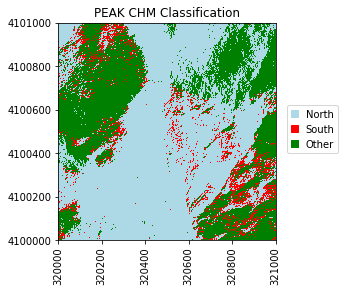

In [8]:
import matplotlib.colors as colors
plt.figure()
cmapCHM = colors.ListedColormap(['lightblue','red','green'])
plt.imshow(serc_chm_reclass,extent=serc_metadata['extent'],cmap=cmapCHM)
plt.title('PEAK CHM Classification')
ax=plt.gca()
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='lightblue', label='North')
class2_box = mpatches.Patch(color='red', label='South')
class3_box = mpatches.Patch(color='green', label='Other')

ax.legend(handles=[class1_box,class2_box,class3_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)